In [1]:
import torch

In [2]:
import sys
import cv2
import numpy as np
from PIL import Image
from omegaconf import OmegaConf
from einops import repeat
from imwatermark import WatermarkEncoder

from ldm.models.diffusion.ddim import DDIMSampler
from ldm.util import instantiate_from_config
from functools import lru_cache

torch.set_grad_enabled(False)

In [3]:
def initialize_model(config, ckpt):
    config = OmegaConf.load(config)
    model = instantiate_from_config(config.model)

    model.load_state_dict(torch.load(ckpt)["state_dict"], strict=False)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device, dtype = torch.float16)
    sampler = DDIMSampler(model)

    return sampler

In [4]:
sampler = initialize_model('SD2Model/v2-inpainting-inference.yaml', 'SD2Model/models/512-inpainting-ema.ckpt')

LatentInpaintDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 20 heads.
Setting up MemoryEfficientCrossAttention. Query 

In [10]:
def put_watermark(img, wm_encoder=None):
    if wm_encoder is not None:
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = wm_encoder.encode(img, 'dwtDct')
        img = Image.fromarray(img[:, :, ::-1])
    return img

def make_batch_sd(
        image,
        mask,
        txt,
        device,
        num_samples=1):
    image = np.array(image.convert("RGB"))
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image).to(dtype=torch.float16) / 127.5 - 1.0

    mask = np.array(mask.convert("L"))
    mask = mask.astype(np.float16) / 255.0
    plt.imshow(mask)
    plt.show()
    mask = mask[None, None]
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    mask = torch.from_numpy(mask)

    masked_image = image * (mask < 0.5)
    plt.imshow(mask[0][0])
    plt.show()
    plt.imshow(masked_image)
    plt.show()


    batch = {
        "image": repeat(image.to(device=device), "1 ... -> n ...", n=num_samples),
        "txt": num_samples * [txt],
        "mask": repeat(mask.to(device=device), "1 ... -> n ...", n=num_samples),
        "masked_image": repeat(masked_image.to(device=device), "1 ... -> n ...", n=num_samples),
    }
    return batch

In [12]:
def inpaint(sampler, image, mask, prompt, seed, scale, ddim_steps, num_samples=1, w=512, h=512, eta=1.):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = sampler.model

    print("Creating invisible watermark encoder (see https://github.com/ShieldMnt/invisible-watermark)...")
    wm = "SDV2"
    wm_encoder = WatermarkEncoder()
    wm_encoder.set_watermark('bytes', wm.encode('utf-8'))

    prng = np.random.RandomState(seed)
    start_code = prng.randn(num_samples, 4, h // 8, w // 8)
    start_code = torch.from_numpy(start_code).to(device=device, dtype=torch.float16)

    with torch.no_grad(), \
            torch.autocast("cuda"):
            batch = make_batch_sd(image, mask, txt=prompt, device=device, num_samples=num_samples)

            c = model.cond_stage_model.encode(batch["txt"])

            c_cat = list()
            for ck in model.concat_keys:
                cc = batch[ck].float()
                if ck != model.masked_image_key:
                    bchw = [num_samples, 4, h // 8, w // 8]
                    cc = torch.nn.functional.interpolate(cc, size=bchw[-2:])
                else:
                    cc = model.get_first_stage_encoding(model.encode_first_stage(cc))
                c_cat.append(cc)
            c_cat = torch.cat(c_cat, dim=1)

            # cond
            cond = {"c_concat": [c_cat], "c_crossattn": [c]}

            # uncond cond
            uc_cross = model.get_unconditional_conditioning(num_samples, "")
            uc_full = {"c_concat": [c_cat], "c_crossattn": [uc_cross]}

            shape = [model.channels, h // 8, w // 8]
            samples_cfg, intermediates = sampler.sample(
                ddim_steps,
                num_samples,
                shape,
                cond,
                verbose=False,
                eta=eta,
                unconditional_guidance_scale=scale,
                unconditional_conditioning=uc_full,
                x_T=start_code,
            )
            x_samples_ddim = model.decode_first_stage(samples_cfg)

            result = torch.clamp((x_samples_ddim + 1.0) / 2.0,
                                 min=0.0, max=1.0)

            result = result.cpu().numpy().transpose(0, 2, 3, 1) * 255
    return [put_watermark(Image.fromarray(img.astype(np.uint8)), wm_encoder) for img in result]


In [29]:
def get_inpainted_image(image,mask,prompt):
    
    seed = 15
    num_samples = 1
    scale = 10.
    ddim_steps = 50
    eta = 0.
    
    w, h = image.size
    print(f"loaded input image of size ({w}, {h})")
    width, height = map(lambda x: x - x % 64, (w, h))  # resize to integer multiple of 32
    image = image.resize((width, height))
    mask = mask.resize((width, height))

    result = inpaint(
        sampler=sampler,
        image=image,
        mask=mask,
        prompt=prompt,
        seed=seed,
        scale=scale,
        ddim_steps=ddim_steps,
        num_samples=num_samples,
        h=height, w=width, eta=eta
    )

    return result

In [34]:
image = Image.fromarray(np.ones((512,512,3),dtype = np.uint8)*255)
mask = Image.fromarray(np.ones((512,512,3),dtype = np.uint8)*255)
prompt = "sunset from beach, artstation"

result = get_inpainted_image(image,mask,prompt)

loaded input image of size (512, 512)
Creating invisible watermark encoder (see https://github.com/ShieldMnt/invisible-watermark)...
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [01:26<00:00,  5.75it/s]


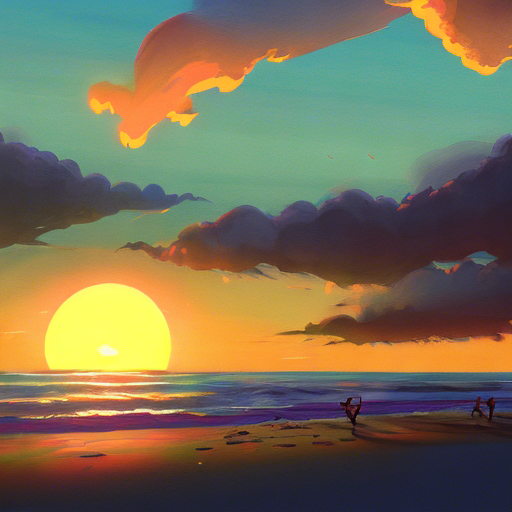

In [35]:
result[0]

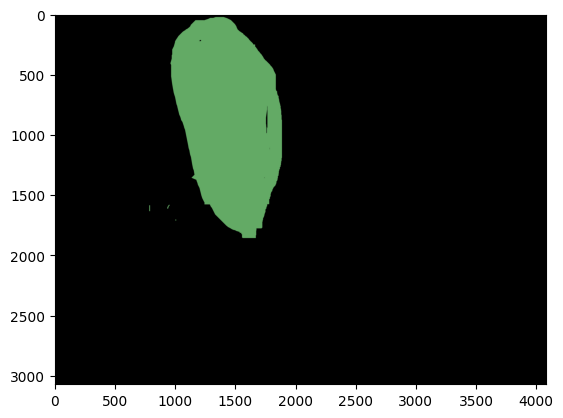

In [11]:
import matplotlib.pyplot as plt
image = cv2.cvtColor(cv2.imread("mask.png"), cv2.COLOR_BGR2RGB)
plt.imshow(image)

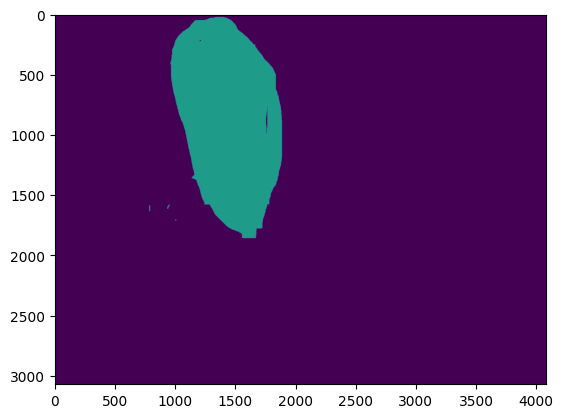

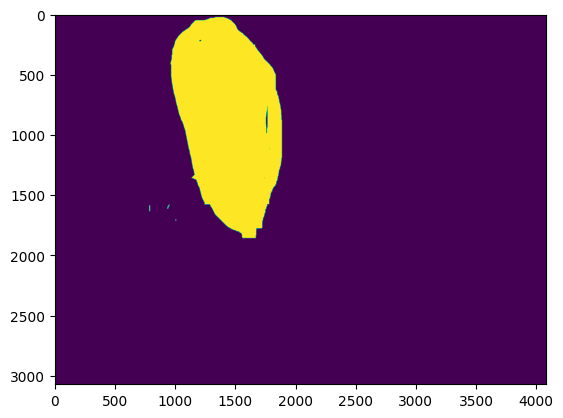

TypeError: Invalid shape (1, 3, 3072, 4080) for image data

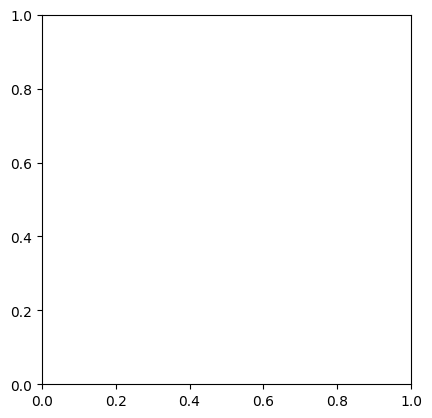

In [12]:
make_batch_sd(Image.fromarray(image),
        Image.fromarray(image),
        "hello",
        'cuda',)